In [169]:
%matplotlib inline
import matplotlib.pyplot as plt
from random import uniform, seed
import numpy as np
import time
import pandas as pd 
import networkx as nx
import jgraph

## Read data 

In [122]:
actors = pd.read_table("movie_nodes.txt",index_col=0,names=["name"])
edges = pd.read_table("movie_edgesw.txt",names=["a","b","weight"])
actor_ind = actors.index

## Create a graph 

In [123]:
G = nx.Graph()
G.add_weighted_edges_from(edges.values)

## Since there's too many nodes, we seperate the graphs into groups

In [124]:
from community import community_louvain
partition = community_louvain.best_partition(G)

In [125]:
par_ser = pd.Series(partition)
par_ser.value_counts()[:45]

3      5063
0      3188
2      3058
1      3056
6      2225
8      1920
7      1634
12     1403
5      1255
4       817
14      483
11      450
10      445
9       419
13      277
15      250
16      187
17      153
19      118
18      107
29       44
22       41
24       24
20       23
52       19
184      11
91       11
30        9
100       8
180       8
111       7
182       7
77        6
85        6
49        6
21        5
70        5
28        5
41        5
149       5
125       5
109       5
81        5
198       5
156       4
dtype: int64

In [221]:
selected_nodes = par_ser[par_ser==22].index # select the group size around 40
H = nx.subgraph(G,selected_nodes)

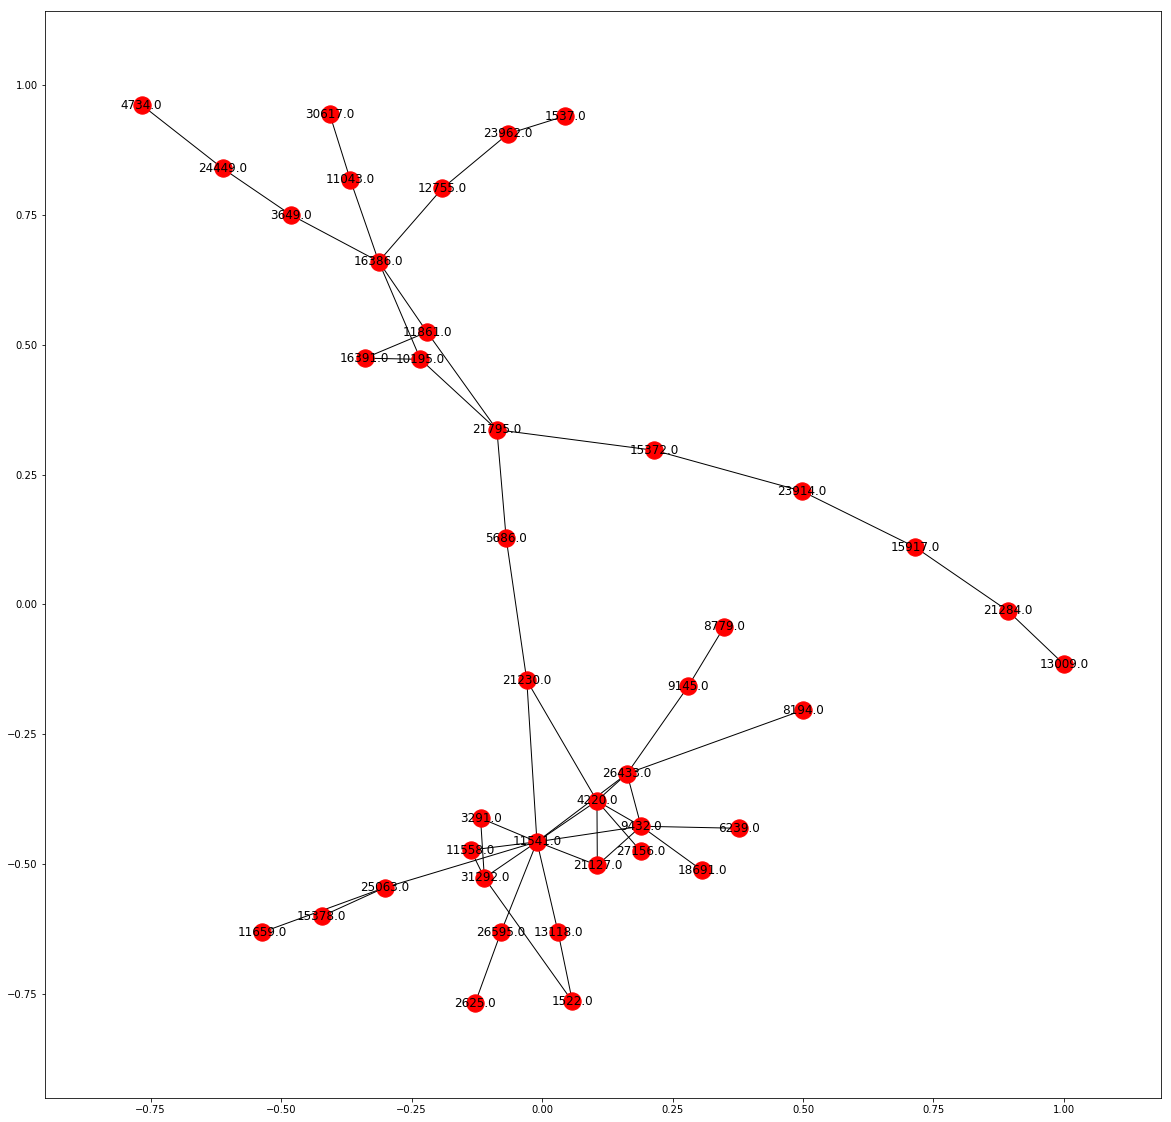

In [222]:
plt.figure(figsize=(20,20))
nx.draw_networkx(H)

In [216]:
def IC(g,S,p=0.5,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    
    # Loop over the Monte-Carlo Simulations
    spread = []
    for i in range(mc):
        
        # Simulate propagation process      
        new_active, A = S[:], S[:]
        while new_active:

            # For each newly active node, find its neighbors that become activated
            new_ones = []
            for node in new_active:
                
                # Determine those neighbors that become infected
                #np.random.seed(i)
                try:
                    neighbor_nodes = list(g.neighbors(node))
                except:
                    print(node)
                    print(S)
                success = np.random.uniform(0,1,len(neighbor_nodes)) < p
                new_ones += list(np.extract(success,neighbor_nodes))

            new_active = list(set(new_ones) - set(A))
            
            # Add newly activated nodes to the set of activated nodes
            A += new_active

        spread.append(len(A))
        
    return(np.mean(spread))

In [143]:
def greedy(g,k,p=0.1,mc=1000):
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """

    S, spread, timelapse, start_time = [], [], [], time.time()
    
    # Find k nodes with largest marginal gain
    for _ in range(k):

        # Loop over nodes that are not yet in seed set to find biggest marginal gain
        best_spread = 0
        for j in set(g.nodes())-set(S):

            # Get the spread
#             print(S,[j])
            s = IC(g,S + [j],p,mc)

            # Update the winning node and spread so far
            if s > best_spread:
                best_spread, node = s, j

        # Add the selected node to the seed set
        S.append(node)
        
        # Add estimated spread and elapsed time
        spread.append(best_spread)
        timelapse.append(time.time() - start_time)

    return(S,spread,timelapse)

In [32]:
def celf(g,k,p=0.1,mc=1000):  
    """
    Input:  graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    """
      
    # --------------------
    # Find the first node with greedy algorithm
    # --------------------
    
    # Calculate the first iteration sorted list
    start_time = time.time() 
    all_nodes = g.nodes()
    marg_gain = [IC(g,[node],p,mc) for node in all_nodes]

    # Create the sorted list of nodes and their marginal gain 
    Q = sorted(zip(all_nodes,marg_gain), key=lambda x: x[1],reverse=True)

    # Select the first node and remove from candidate list
    S, spread, SPREAD = [Q[0][0]], Q[0][1], [Q[0][1]]
    Q, LOOKUPS, timelapse = Q[1:], [len(all_nodes)], [time.time()-start_time]
    
    # --------------------
    # Find the next k-1 nodes using the list-sorting procedure
    # --------------------
    
    for _ in range(k-1):    

        check, node_lookup = False, 0
        
        while not check:
            
            # Count the number of times the spread is computed
            node_lookup += 1
            
            # Recalculate spread of top node
            current = Q[0][0]
            
            # Evaluate the spread function and store the marginal gain in the list
            Q[0] = (current,IC(g,S+[current],p,mc) - spread)

            # Re-sort the list
            Q = sorted(Q, key = lambda x: x[1], reverse = True)

            # Check if previous top node stayed on top after the sort
            check = (Q[0][0] == current)

        # Select the next node
        spread += Q[0][1]
        S.append(Q[0][0])
        SPREAD.append(spread)
        LOOKUPS.append(node_lookup)
        timelapse.append(time.time() - start_time)

        # Remove the selected node from the list
        Q = Q[1:]

    return(S,SPREAD,timelapse,LOOKUPS)

In [223]:
class Simulation_Annealing:
    
    def __init__(self,Graph ,temperature, cool_rate,top_k,
                 loss_function, tolerance,iter_temperature,
                 max_iter=20000 ):
        '''
        Temperature decreasing with velocity `cooling_rate`
        Algorithm stop when temperature below tolerance or exceed max iteration.
        '''
        self.G = Graph
        self.T = temperature
        self.cooling_rate = cool_rate
        self.k = top_k
        self.E = loss_function
        self.tol = tolerance
        self.iter_loop = iter_temperature
        self.max_iter = max_iter
        self.history = {'x' : [], 'E' : []}
         
    def run(self,p=0.5):
        pre  = np.random.choice(self.G.nodes(), size=self.k, replace=False).tolist()
        energy_pre = self.E(self.G,pre,p=p)
        i = 0 
        while (self.T > self.tol) and (i < self.max_iter)  :
            i+=1
            for _ in range(self.iter_loop):
                new_state = np.random.choice(self.G.nodes(), size=self.k, replace=False).tolist()
                energy_new = self.E(self.G,new_state,p=p)
                delta_E = energy_new - energy_pre

                if delta_E > 0:
                    pre, energy_pre = new_state, energy_new
                elif uniform(0,1) < np.exp(delta_E/self.T):
                    pre, energy_pre = new_state, energy_new
            
            self.T *= self.cooling_rate
            # T /= rate seems to converge slow
            self.history['x'].append(pre)
            self.history['E'].append(energy_pre)
        self.final = self.history["x"][np.argmax(self.history["E"])]
        return self.final
            
    def plot(self, **kargs):
        plt.title('History energy')
        plt.xlabel('Iteration')
        plt.ylabel('Energy')
        plt.plot(self.history['E'], **kargs)
        

In [224]:
# Run algorithms
celf_output   = celf(H,4,p=0.2,mc=1000)
# greedy_output = greedy(H,4,p=0.2,mc=1000)

# Print results
print("celf output:   " + str(celf_output[0]))
# print("greedy output: " + str(greedy_output[0]))

celf output:   [11541.0, 16386.0, 15372.0, 9432.0]


In [226]:
sa = Simulation_Annealing(H,20,0.9,4,IC,0.1,5)
sa_output = sa.run(p=0.2)
print("sa output:     " + str(sa_output))

sa output:     [11861.0, 9432.0, 11541.0, 3649.0]


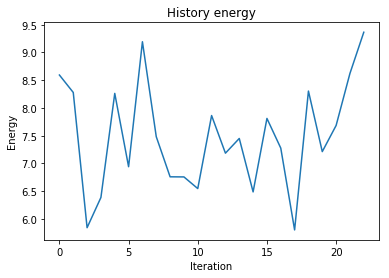

In [227]:
sa.plot()